# Chapter 14 Exercises

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

def save_fig(fig_id, tight_layout=True):
    path = os.path.join("images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Embedded Reber grammars were used by Hochreiter and Schmidhuber in their paper about LSTMs. They are artificial grammars that produce strings such as “BPBTSXXVPSEPE.” Check out Jenny Orr’s nice introduction to this topic. Choose a particular embedded Reber grammar (such as the one represented on Jenny Orr’s page), then train an RNN to identify whether a string respects that grammar or not. You will first need to write a function capable of generating a training batch containing about 50% strings that respect the grammar, and 50% that don’t.

In [3]:
from random import choice, seed

Reber Grammar
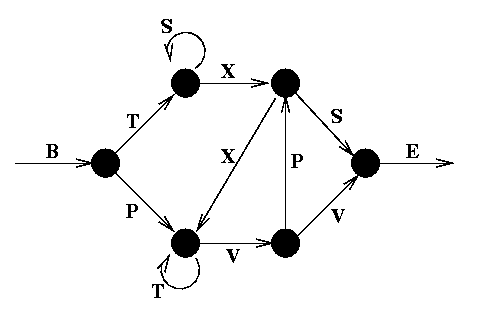

In [4]:
# I'm defining nodes as 1, then top two as 2 and 4, bottom two as 3 and 5, last as 6
nodes = [    
    [[("T",2),("P",3)],1],  # starting node 1
    [[("S",2),("X",4)],2],  # node 2  
    [[("T",3),("V",5)],3],  # node 3
    [[("X",3),("S",6)],4],  # node 4
    [[("P",4),("V",6)],5],  # node 5
]

def gen_reber_str():
    output = ["B"]
    tmp = choice(nodes[0][0])
    output.append(tmp[0])
    
    while tmp[1] != 6:
        tmp = choice(nodes[tmp[1]-1][0])
        output.append(tmp[0])
    
    output.append("E")
    return "".join(output)

In [5]:
gen_reber_str()

'BPVPXTVPSE'

Embedded Reber Grammar
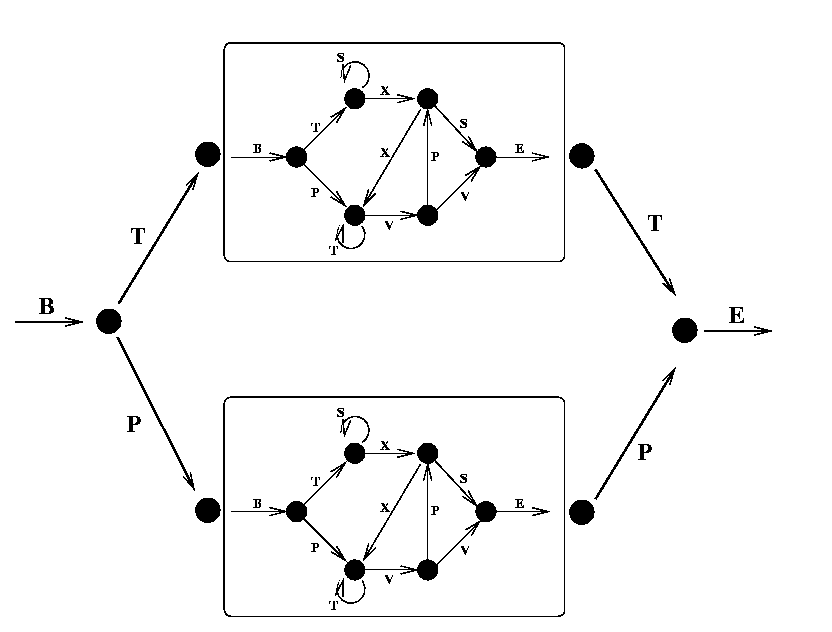

In [6]:
def gen_emb_reber():
    output = []
    decision = choice([0,1])
    if decision:
        output.append("BP")
        output.append(gen_reber_str())
        output.append("PE")
    else:
        output.append("BT")
        output.append(gen_reber_str())
        output.append("TE")
        
    return "".join(output)

In [7]:
gen_emb_reber()

'BTBTXXVVETE'

In [8]:
# Picks a random char from a valid emb. reber string and swaps all the chars with a different random one
# from the set of valid chars
def gen_emb_bad():
    sample = gen_emb_reber()
    swap = choice(list(sample))
    char = choice(list(set('BTPSXVE') - set(swap)))
    output = sample.replace(swap,char)
    return output

In [9]:
gen_emb_bad()

'BEBTSXXTVESEEE'

In [10]:
# One hot vectorify the strings, and add zero padding to the end if string is less than the max len. str so all 
# inputs are same dim.
def one_hot_vectorify(string, n_steps, chars="BTPSXVE"):
    char_index = {char: index for index, char in enumerate(chars)}
    output = np.zeros((n_steps, len(chars)), dtype=np.int32)
    for ind, char in enumerate(string):
        output[ind, char_index[char]] = 1
    return output

In [11]:
one_hot_vectorify('BTBTXSETE', 10)

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [12]:
def gen_dataset(num):
    '''
    Generates a dataset such that half of the strings are valid embedded reber grammar, and the other half is not.
    
    num: even integer
    '''
    good = [gen_emb_reber() for i in range(num//2)]
    bad = [gen_emb_bad() for i in range(num - num//2)]
    strings = good + bad
    max_length = max([len(string) for string in strings])
    x = np.array([one_hot_vectorify(string, max_length) for string in strings])
    length = np.array([len(string) for string in strings])
    y = np.hstack((np.ones((len(good)),dtype=np.int32), np.zeros((len(bad)),dtype=np.int32)))
    index = np.random.permutation(num)
    return x[index], length[index], y[index]

In [13]:
X_train, l_train, y_train = gen_dataset(5000)
X_val, l_val, y_val = gen_dataset(1000)

In [14]:
reset_graph()

In [15]:
char_set = "BTPSXVE"
n_inputs = len(char_set)
n_neurons = 50
n_layers = 3
n_outputs = 1

In [16]:
X = tf.placeholder(tf.float32, [None, None, n_inputs])
seq_length = tf.placeholder(tf.int32, [None])
y = tf.placeholder(tf.float32, [None,1], name='y')

layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons) for layer in range(n_layers)]

#gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, sequence_length=seq_length,dtype=tf.float32)

states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
y_pred = tf.cast(tf.greater(logits, 0.), tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)
correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
tf.summary.scalar('accuracy', accuracy)

init = tf.global_variables_initializer()

In [17]:
# Because tf is yelling at me
y_val = y_val.reshape(len(y_val),1)

In [18]:
n_epochs = 5
batch_size = 50
counter = 0

with tf.Session() as sess:
    train_writer = tf.summary.FileWriter( './logs/train ', sess.graph)
    init.run()
    for epoch in range(n_epochs):
        X_batches = np.array_split(X_train, len(X_train) // batch_size)
        l_batches = np.array_split(l_train, len(l_train) // batch_size)
        y_batches = np.array_split(y_train, len(y_train) // batch_size)
        for X_batch, l_batch, y_batch in zip(X_batches, l_batches, y_batches):
            merge = tf.summary.merge_all()
            counter += 1
            y_batch = y_batch.reshape(batch_size,1)
            summary, loss_val, _ = sess.run(
                [merge, loss, training_op],
                feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
            train_writer.add_summary(summary, counter)
        acc_train = accuracy.eval(feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, seq_length: l_val, y: y_val})
        print("{:4d}  Train loss: {:.4f}, accuracy: {:.2f}%  Validation accuracy: {:.2f}%".format(
            epoch, loss_val, 100 * acc_train, 100 * acc_val))

   0  Train loss: 0.6763, accuracy: 64.00%  Validation accuracy: 65.30%
   1  Train loss: 0.3726, accuracy: 86.00%  Validation accuracy: 83.20%
   2  Train loss: 0.2040, accuracy: 96.00%  Validation accuracy: 93.50%
   3  Train loss: 0.1079, accuracy: 98.00%  Validation accuracy: 96.00%
   4  Train loss: 0.1070, accuracy: 98.00%  Validation accuracy: 97.60%


Tackle the “How much did it rain? II” Kaggle competition. This is a time series prediction task: you are given snapshots of polarimetric radar values and asked to predict the hourly rain gauge total. Luis Andre Dutra e Silva’s interview gives some interesting insights into the techniques he used to reach second place in the competition. In particular, he used an RNN composed of two LSTM layers.

In [170]:
import pandas as pd

In [171]:
train = pd.read_csv('train.csv')

In [174]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13765201 entries, 0 to 13765200
Data columns (total 24 columns):
Id                       int64
minutes_past             int64
radardist_km             float64
Ref                      float64
Ref_5x5_10th             float64
Ref_5x5_50th             float64
Ref_5x5_90th             float64
RefComposite             float64
RefComposite_5x5_10th    float64
RefComposite_5x5_50th    float64
RefComposite_5x5_90th    float64
RhoHV                    float64
RhoHV_5x5_10th           float64
RhoHV_5x5_50th           float64
RhoHV_5x5_90th           float64
Zdr                      float64
Zdr_5x5_10th             float64
Zdr_5x5_50th             float64
Zdr_5x5_90th             float64
Kdp                      float64
Kdp_5x5_10th             float64
Kdp_5x5_50th             float64
Kdp_5x5_90th             float64
Expected                 float64
dtypes: float64(22), int64(2)
memory usage: 2.5 GB


In [176]:
train.describe()

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
count,1.376520e+07,1.376520e+07,1.376520e+07,6.349375e+06,5.283988e+06,6.356482e+06,7.551281e+06,6.716343e+06,5.755673e+06,6.711663e+06,...,5.905584e+06,4.934916e+06,4.133154e+06,4.936568e+06,5.905584e+06,4.182635e+06,3.428782e+06,4.187281e+06,5.052776e+06,1.376520e+07
mean,5.923370e+05,2.952373e+01,1.106794e+01,2.292666e+01,1.995227e+01,2.261029e+01,2.589846e+01,2.471108e+01,2.215824e+01,2.442075e+01,...,1.015272e+00,5.367092e-01,-7.190076e-01,3.376216e-01,2.072870e+00,3.545172e-02,-3.482325e+00,-4.736553e-01,4.079836e+00,1.086263e+02
std,3.408561e+05,1.730813e+01,4.206618e+00,1.035516e+01,9.208166e+00,1.005300e+01,1.110958e+01,1.068962e+01,9.702705e+00,1.042453e+01,...,4.861606e-02,1.510399e+00,1.006068e+00,9.386440e-01,1.670194e+00,3.869725e+00,2.792120e+00,2.263046e+00,4.147337e+00,5.486058e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,-3.100000e+01,-3.200000e+01,-3.200000e+01,-2.850000e+01,-3.200000e+01,-3.100000e+01,-2.750000e+01,...,2.083333e-01,-7.875000e+00,-7.875000e+00,-7.875000e+00,-7.875000e+00,-9.604000e+01,-8.079000e+01,-7.877000e+01,-1.002000e+02,1.000000e-02
25%,2.968970e+05,1.500000e+01,9.000000e+00,1.600000e+01,1.400000e+01,1.600000e+01,1.800000e+01,1.750000e+01,1.600000e+01,1.750000e+01,...,9.983333e-01,-1.875000e-01,-1.125000e+00,-6.250000e-02,1.062500e+00,-1.410004e+00,-4.580002e+00,-7.100067e-01,2.069992e+00,2.540001e-01
50%,5.921990e+05,3.000000e+01,1.100000e+01,2.250000e+01,2.000000e+01,2.250000e+01,2.550000e+01,2.400000e+01,2.200000e+01,2.400000e+01,...,1.011667e+00,3.750000e-01,-6.250000e-01,2.500000e-01,1.687500e+00,0.000000e+00,-2.820007e+00,0.000000e+00,3.519989e+00,1.016000e+00
75%,8.895820e+05,4.400000e+01,1.400000e+01,2.950000e+01,2.600000e+01,2.900000e+01,3.350000e+01,3.150000e+01,2.850000e+01,3.150000e+01,...,1.051667e+00,1.062500e+00,-1.875000e-01,6.875000e-01,2.625000e+00,1.750000e+00,-1.760010e+00,3.499908e-01,5.639999e+00,3.810002e+00
max,1.180945e+06,5.900000e+01,2.100000e+01,7.100000e+01,6.250000e+01,6.900000e+01,7.250000e+01,9.250000e+01,6.600000e+01,7.100000e+01,...,1.051667e+00,7.937500e+00,7.937500e+00,7.937500e+00,7.937500e+00,1.797500e+02,3.519989e+00,1.280000e+01,1.446000e+02,3.301773e+04


In [178]:
train.head(15)

,Id,minutes_past,radardist_km,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
0,1,3,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
1,1,16,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
2,1,25,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
3,1,35,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
4,1,45,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
5,1,55,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254
6,2,1,2.0,9.0,5.0,7.5,10.5,15.0,10.5,16.5,...,0.998333,0.3750,-0.1250,0.3125,0.8750,1.059998,-1.410004,-0.350006,1.059998,1.016
7,2,6,2.0,26.5,22.5,25.5,31.5,26.5,26.5,28.5,...,1.005000,0.0625,-0.1875,0.2500,0.6875,NaN,NaN,NaN,1.409988,1.016
8,2,11,2.0,21.5,15.5,20.5,25.0,26.5,23.5,25.0,...,1.001667,0.3125,-0.0625,0.3125,0.6250,0.349991,NaN,-0.350006,1.759994,1.016
9,2,16,2.0,18.0,14.0,17.5,21.0,20.5,18.0,20.5,...,1.001667,0.2500,0.1250,0.3750,0.6875,0.349991,-1.059998,0.000000,1.059998,1.016
